In [46]:
# ===== IMPORTS & DEVICE SETUP =====
import os, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Choose device automatically
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"✅ Using device: {device}")

# Avoid hangs on macOS
torch.set_num_threads(1)

✅ Using device: mps


In [40]:
# ===== DATASET CLASS =====
class ChipsDataset(Dataset):
    """
    Custom dataset for xBD chips. 
    Each row in the CSV must have 'image_path' and 'label_int'.
    """

    def __init__(self, csv_file, root=".", transform=None):
        df = pd.read_csv(csv_file).reset_index(drop=True)
        self.df = df
        self.root = root
        self.transform = transform
        print(f"✅ Loaded {len(self.df)} samples from {csv_file}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        idx = int(idx) % len(self.df)
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["image_path"])

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            img = Image.new("RGB", (224, 224), color=(0, 0, 0))

        if self.transform:
            img = self.transform(img)

        label = int(row["label_int"])
        return img, label

In [ ]:
# ===== CREATE DATASETS & DATALOADERS =====
tfm_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

tfm_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = ChipsDataset("chips_post/tier1/train.csv", transform=tfm_train)
val_ds   = ChipsDataset("chips_post/tier1/val.csv", transform=tfm_eval)
test_ds  = ChipsDataset("chips_post/tier1/test.csv", transform=tfm_eval)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

# Quick sanity check
xb, yb = next(iter(train_loader))
print("✅ DataLoaders ready:", xb.shape, yb[:5])


✅ Loaded 260458 samples from chips_post/tier1/train.csv
✅ Loaded 32557 samples from chips_post/tier1/val.csv
✅ Loaded 32558 samples from chips_post/tier1/test.csv
✅ DataLoaders ready: torch.Size([32, 3, 224, 224]) tensor([3, 2, 1, 0, 0])


In [42]:
# ===== MODEL SETUP =====
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 damage classes
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

print("✅ Model ready")

✅ Model ready


In [43]:
# ===== TRAINING LOOP =====
def run_epoch(loader, train=False):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
        if train and (i % 25 == 0):
            print(f"  step {i:04d} | loss {loss.item():.4f}", end="\r")
    return loss_sum / total, correct / total

EPOCHS = 5  # Start small first
best_val_acc, best_state = 0.0, None

for epoch in range(EPOCHS):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"train acc {tr_acc:.3f} | val acc {va_acc:.3f} "
          f"| time {time.time()-t0:.1f}s")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

Epoch 01/5 | train acc 0.810 | val acc 0.821 | time 2135.3s
Epoch 02/5 | train acc 0.830 | val acc 0.841 | time 4770.4s
Epoch 03/5 | train acc 0.838 | val acc 0.844 | time 2175.5s
Epoch 04/5 | train acc 0.843 | val acc 0.848 | time 2135.8s
Epoch 05/5 | train acc 0.848 | val acc 0.853 | time 2152.4s


In [44]:
# ===== SAVE BEST MODEL =====
if best_state:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    torch.save(model.state_dict(), "baseline_resnet18.pt")
    print(f"✅ Training complete. Best val acc: {best_val_acc:.3f}")
else:
    print("⚠️ No best model found. Check data or labels.")
    

✅ Training complete. Best val acc: 0.853


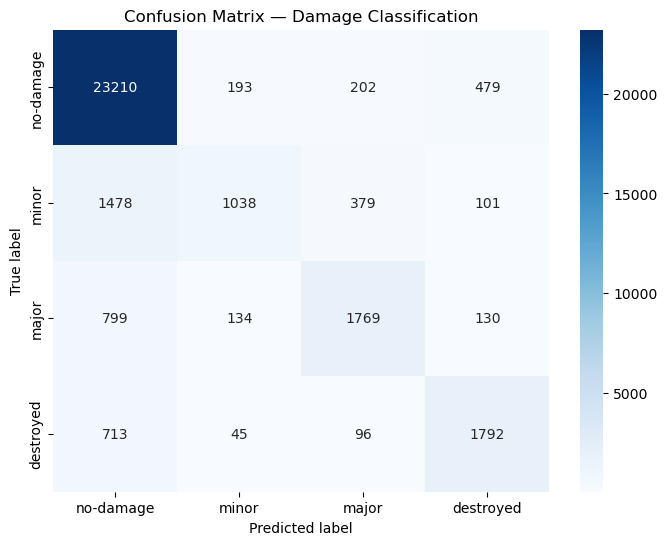

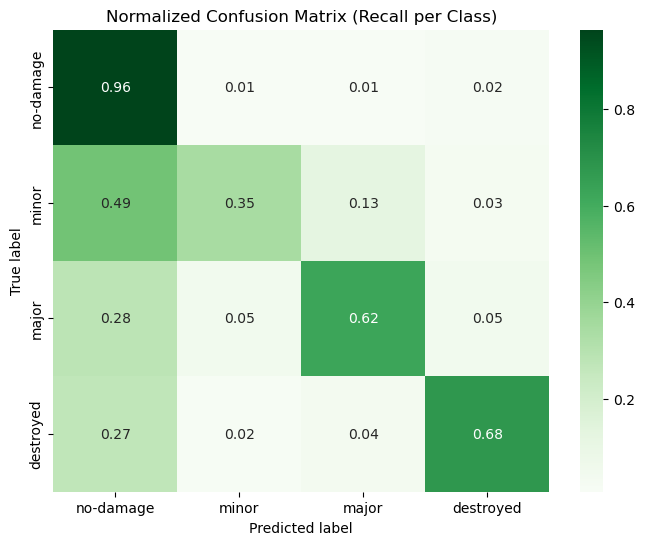

Classification Report:

              precision    recall  f1-score   support

   no-damage      0.886     0.964     0.923     24084
       minor      0.736     0.346     0.471      2996
       major      0.723     0.625     0.670      2832
   destroyed      0.716     0.677     0.696      2646

    accuracy                          0.854     32558
   macro avg      0.765     0.653     0.690     32558
weighted avg      0.844     0.854     0.841     32558



In [47]:
# Evaluate on test set
model.eval()
all_y, all_p = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x).argmax(1).cpu()
        all_y.extend(y.tolist())
        all_p.extend(preds.tolist())

# Compute metrics
cm = confusion_matrix(all_y, all_p)
report = classification_report(all_y, all_p, output_dict=True, digits=3)
classes = ["no-damage", "minor", "major", "destroyed"]

# ---- Confusion Matrix Heatmap ----
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix — Damage Classification")
plt.show()

# ---- Normalized Heatmap (percentages) ----
cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Recall per Class)")
plt.show()

# ---- Print classification report neatly ----
print("Classification Report:\n")
print(classification_report(all_y, all_p, target_names=classes, digits=3))